# Normalization

Instead of discretizing each of the features into bins (low, normal, high) and setting the Basismaß to 0.5, we could use 0 to 1 normalized values as "degree of how high or low" each of the features was in the last 10 seconds.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

In [8]:
df1 = pd.read_csv('../data/E_B02_Sequenz_1.csv', delimiter=';')
df2 = pd.read_csv('../data/E_B02_Sequenz_2.csv', delimiter=';')
df3 = pd.read_csv('../data/E_B02_Sequenz_3.csv', delimiter=';')

df = df1.append(df2).append(df3)
print(len(df), len(df1), len(df2), len(df3))


df.head()

255 87 84 84


,geschwindigkeit,tonlage,schallstaerke
0,87,257,33
1,84,227,33
2,82,231,34
3,79,240,37
4,76,232,41


Example: with how much confidence was the pitch `high` in the last 10 seconds of the first sequence?

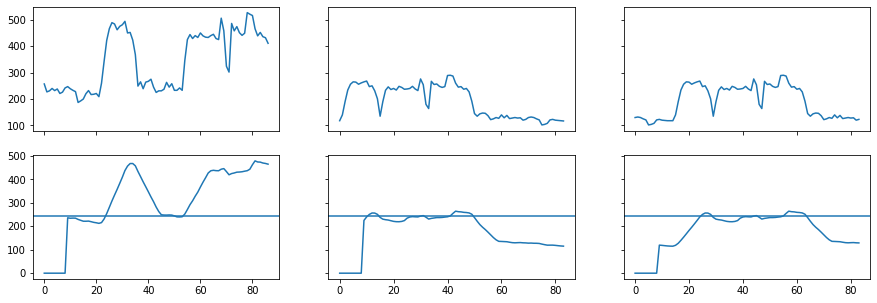

In [20]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['tonlage'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['tonlage'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)

for window, ax in zip(windows, window_axes):
    window.mean().fillna(0).plot(ax=ax)
    ax.axhline(df['tonlage'].mean())

In [52]:
from sklearn.preprocessing import MinMaxScaler

pitch_scaler = MinMaxScaler().fit(df['tonlage'].to_numpy().reshape(-1, 1))

In [53]:
mean_pitch_last_ten = df1.rolling(window=10)['tonlage'].mean().to_numpy()[-1].reshape(-1, 1)
mean_pitch_last_ten, df['tonlage'].mean(), pitch_scaler.transform(mean_pitch_last_ten)

(array([[464.9]]), 244.09019607843138, array([[0.85388235]]))

We are 85% confident that the pitch is "high". Which gives us one piece of evidence:

    m1(Ü, A, E, W) = 0.8538, m1(Omega) = 0.146